### Importing python libraries for data analysis, visualization and time series forecasting model(prophet)

In [587]:
import json
import requests
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from geopy.distance import great_circle
from geopy.exc import GeocoderTimedOut
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import seaborn as sns
import pystan
%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
from datetime import date
import holidays


### Extracted Crime Data in Seattle area from crimereports.com (https://www.crimereports.com/) and performed data wrangling 

In [588]:
filename = "https://moto.data.socrata.com/resource/4h35-4mtu.json?$$app_token=SGf4MCedoqeOfxb7GPiMDUdf7"
response = requests.get(filename)
data = response.json()

#Data is represented in the form of Data frame 
df = pd.DataFrame(data)

#checking for null values
print(df.isnull().values.all())
print(df.isnull().sum())

#checking for data types
print(df.dtypes)

#converting data types 
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])

#looking for erroneous data
tempdf_1 = df[df['created_at'] < df['incident_datetime']] 

tempdf_2 = df[df['updated_at'] < df['created_at']]

#cleaning erroneous data:
parsed_df = df[df['created_at'] >= df['incident_datetime']]


False
address_1                0
case_number              0
city                     0
clearance_type           0
created_at               0
day_of_week              0
hour_of_day              0
incident_datetime        0
incident_description     0
incident_id              0
incident_type_primary    0
latitude                 0
location                 0
longitude                0
parent_incident_type     0
state                    0
updated_at               0
zip                      6
dtype: int64
address_1                object
case_number              object
city                     object
clearance_type           object
created_at               object
day_of_week              object
hour_of_day              object
incident_datetime        object
incident_description     object
incident_id              object
incident_type_primary    object
latitude                 object
location                 object
longitude                object
parent_incident_type     object
state          

### Interested in finding crime rate predictions of any of the following Starbucks retail stores in seattle

In [589]:
store1 = '1912 Pike Place Seattle, WA 98101'
store2 = '4634 26th Avenue NE Seattle, WA 98105'
store3 = '10002 Aurora Avenue North Seattle, WA 98133' 
store4 = '3300 W. McGraw St. Seattle, WA 98119'
store5 = '1125 4th Avenue Seattle, WA 98101'


### Finding the latitude and longitude of Starbucks retail stores

In [590]:

location_list = {}
locator = Nominatim()
my_address = ['1912 Pike Place Seattle, WA 98101','4634 26th Avenue NE Seattle, WA 98105',
            '10002 Aurora Avenue North Seattle, WA 98133','3300 W. McGraw St. Seattle, WA 98119',
            '1125 4th Avenue Seattle, WA 98101']
for i in my_address:
    try:
        location_list[i] = (locator.geocode(i).latitude,locator.geocode(i).longitude)
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s"%(i, e.msg))




### Categorized Crimes into  following 3 Categories

In [591]:
Quality = ["Drugs","Liquor","Other","Traffic","Disorder","Quality of Life","Fire"]
Property = ["Property Crime","Robbery","Theft","Theft of Vehicle","Theft from Vehicle","Breaking & Entering"]
Violent = ["Assualt","Assault with Deadly Weapon","Homicide","Kidnapping","Other Sexual Offense","Sexual Assault","Sexual Offense"]


### Finding crime rates near starbucks stores by each crime category

In [592]:
def getcrimesby_tier(store,crime_type):
    tier = []
    dictionary = {}
    for i,r in parsed_df.iterrows():
        coordinates  = (r.latitude,r.longitude)
        distance = great_circle(location_list[store],coordinates).miles
        days = (datetime.now().date() - r.incident_datetime.date()).days
        if (distance < 20 and days < 365 ):
            if(r.parent_incident_type in crime_type):
                if (r.incident_datetime.date()) not in dictionary:
                    dictionary[r.incident_datetime.date()] = 1
                else:
                    dictionary[r.incident_datetime.date()] = dictionary[r.incident_datetime.date()] + 1
                    
    for key ,value in dictionary.items():
        tier.append([key,value])

    #return tier
    return pd.DataFrame(tier,columns = ['Date','Incidents']) 


### Using Forecasting Model -  Prophet 

Prophet is "robust to outliers, missing data, and dramatic changes in the time series".

So am going to try 3 different models:
- Normal Model (without removing outliers)
- No Outliers Model (removing outliers)
- Holiday Model (Including holidays)

###  Normal Model

#### Getting crime rates data for store 1 by each crime category:
- Tier1 (Quality)
- Tier2 (Property)
- Tier3 Violent)

In [593]:
tier1 = getcrimesby_tier(store1,Quality)
tier1_df = tier1.copy()

In [594]:
tier2 = getcrimesby_tier(store1,Property)
tier2_df = tier2.copy()

In [595]:
tier3 = getcrimesby_tier(store1,Violent)
tier3_df = tier3.copy()

#### Forecast model for Tier 1 Crimes

In [596]:
df1 = tier1_df.reset_index()
#for prophet to work, columns should be in teh format ds and y
df1 = df1.rename(columns={'Date':'ds', 'Incidents':'y'})

In [597]:
#make a copy of dataframe
df1_normal = df1.copy()
    
#converting normal values to log values using numpy's log function to remove anamolies
df1_normal['y'] = np.log(df1_normal['y'])

##### Running with Prophet

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


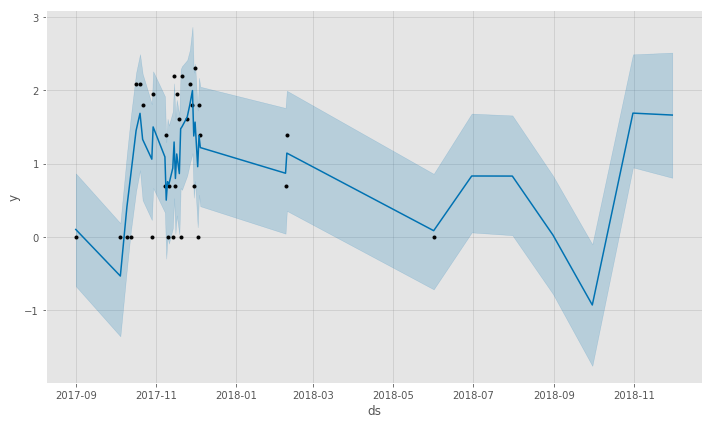

In [598]:
#Running Prophet with seasonalities
normal_model = Prophet(yearly_seasonality =True,weekly_seasonality= True,daily_seasonality = True)
normal_model.fit(df1_normal);
    
#I want to forecast 6 months of data, so am using periods = 6 and "m" means month
normal_future = normal_model.make_future_dataframe(periods= 6 , freq = 'M')    

#to forecast this future data we have to run it through prophet model   
normal_forecast = normal_model.predict(normal_future)
plotzero = normal_model.plot(normal_forecast)


The black dots are actual values and blue lines are forecast values

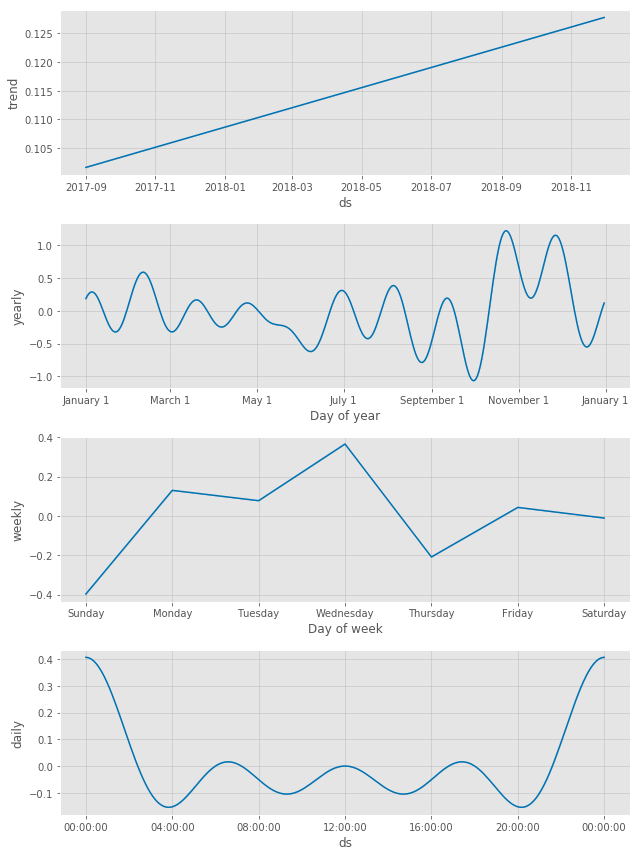

In [599]:
plotone = normal_model.plot_components(normal_forecast)

The results are pretty interesting for store1 
- The first graph shows that july and august are having similar forecast values , and the october has a huge downfall and sudden   rise in November.Seems like we will see more crimes in November under Tier1 for store1
- Weekly plot shows that mostly crimes under tier1 for store1 happen on wednesday and less on sunday
- daily plot shows that most tier1 criems for store1 happen at midnight 12am<br> 

Similarly we can forecast the other tiers(tier2 and tier3) for store1

Now let's measure the error for this model. For that, I'll be using the Mean Absolute Percentage Error (MAPE).

In [600]:
df1 = tier1_df.reset_index()
    
#for prophet to work, columns should be in teh format ds and y
df1 = df1.rename(columns={'Date':'ds', 'Incidents':'y'})

df_orig = df1['y'].to_frame()
df_orig.index = df1['ds']
n = np.int(df_orig.count())

In [601]:
# Inverse the log
normal_forecast_exp = np.exp(normal_forecast[['yhat','yhat_lower','yhat_upper']])
normal_forecast_exp.index = normal_forecast['ds']
    
# Calculate the error
normal_model_error = normal_forecast_exp['yhat'] - df_orig['y']
MAPE_for_normal_model = (normal_model_error/df_orig['y']).abs().sum()/n *100
print ("Normal model error: ",round(MAPE_for_normal_model,2))

Normal model error:  63.87


### No Outliers Model

#### Forecast Model for Tier1 crimes

In [602]:
df2 = tier1_df.reset_index()

#for prophet to work, columns should be in the format ds and y
df2 = df2.rename(columns={'Date':'ds', 'Incidents':'y'})

In [603]:
#make a copy of dataframe
df2_no_outliers = df2.copy()
    
#converting normal values to log values using numpy's log function to remove anamolies
df2_no_outliers['y'] = np.log(df2_no_outliers['y'])

#####  we know that 99.99 % of data lies within the 3 standard deviations.So am removing data which is 3 standard deviation above and below mean

In [607]:
# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
upper = df2_no_outliers.mean() + df2_no_outliers.std()*3
lower = df2_no_outliers.mean() - df2_no_outliers.std()*3
   
# Remove them by setting their value to None
df2_no_outliers.loc[df2_no_outliers['y'] > upper['y'], 'y'] = None
df2_no_outliers.loc[df2_no_outliers['y'] < lower['y'], 'y'] = None

##### Running with Prophet

In [608]:
no_outliers_model = Prophet(yearly_seasonality =True,weekly_seasonality= True,daily_seasonality = True)
no_outliers_model.fit(df1_no_outliers);
    
#I want to forecast 6 months of data, so am using periods = 6 and "m" means month
no_outliers_future = no_outliers_model.make_future_dataframe(periods= 6, freq = "m")
    
#to forecast this future data we have to run it through prophet model   
no_outliers_forecast = no_outliers_model.predict(no_outliers_future)

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 15.0.


##### No outliers model error

In [609]:
df2 = tier1_df.reset_index()
    
#for prophet to work, columns should be in teh format ds and y
df2 = df2.rename(columns={'Date':'ds', 'Incidents':'y'})

df_orig = df2['y'].to_frame()
df_orig.index = df2['ds']
n = np.int(df_orig.count())

In [610]:
# Inverse the log
no_outliers_forecast_exp = np.exp(no_outliers_forecast[['yhat','yhat_lower','yhat_upper']])
no_outliers_forecast_exp.index = no_outliers_forecast['ds']

no_outliers_error = no_outliers_forecast_exp['yhat'] - df_orig['y']
MAPE_no_outliers_model = (no_outliers_error/df_orig['y']).abs().sum()/n *100
print ("No outliers model error: ",round(MAPE_no_outliers_model,2))

No outliers model error:  30.94


### Holidays Model

#### Preparing Holidays list in Washington,USA

In [611]:
holiday_list = []
for date, name in sorted(holidays.US(state='WA', years=(2017,2018)).items()):
    holiday_list.append(date)
holidays_df = pd.DataFrame({
        'holiday': 'US-WA',
        'ds' :pd.to_datetime(
            holiday_list), 
    })

#### Forecast Model for Tier1 Crimes

In [612]:
df3 = tier1_df.reset_index()

#for prophet to work, columns should be in the format ds and y
df3 = df3.rename(columns={'Date':'ds', 'Incidents':'y'})

In [613]:
#make a copy of dataframe
df3_holidays = df3.copy()
#converting normal values to log values using numpy's log function to remove anamolies
df3_holidays['y'] = np.log(df3_holidays['y'])

##### Running Prophet

In [614]:
holiday_model = Prophet(holidays=holidays_df,yearly_seasonality =True,weekly_seasonality= True,daily_seasonality = True)
holiday_model.fit(df3_holidays);

#I want to forecast 6 months of data, so am using periods = 6 and "m" means month
holiday_future = holiday_model.make_future_dataframe(periods= 6, freq = "m")

#to forecast this future data we have to run it through prophet model   
holiday_forecast = holiday_model.predict(holiday_future)



INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


##### Holiday Model Error

In [615]:
df3 = tier1_df.reset_index()
    
#for prophet to work, columns should be in teh format ds and y
df3 = df3.rename(columns={'Date':'ds', 'Incidents':'y'})

df_orig = df3['y'].to_frame()
df_orig.index = df3['ds']
n = np.int(df_orig.count())

In [616]:
# Inverse the log
holiday_forecast_exp = np.exp(holiday_forecast[['yhat','yhat_lower','yhat_upper']])
holiday_forecast_exp.index = holiday_forecast['ds']

# Calculate the error
holiday_error = holiday_forecast_exp['yhat'] - df_orig['y']
MAPE_holiday_model = (holiday_error/df_orig['y']).abs().sum()/n *100
print ("Holidays model error: ",round(MAPE_holiday_model,2))

Holidays model error:  64.25


### Comparing errors

- Normal model error:  63.87
- No outliers model error:  30.94
- Holidays model error:  64.25
    
By comparing the above errors , No outliers Model with removal of outliers has the best result "No Outliers Model"<br>
Similarly I calculated the errors all the three models for tier2 and tier3 crime data. I got less error value for No outliers Model<br>
Lets plot now!

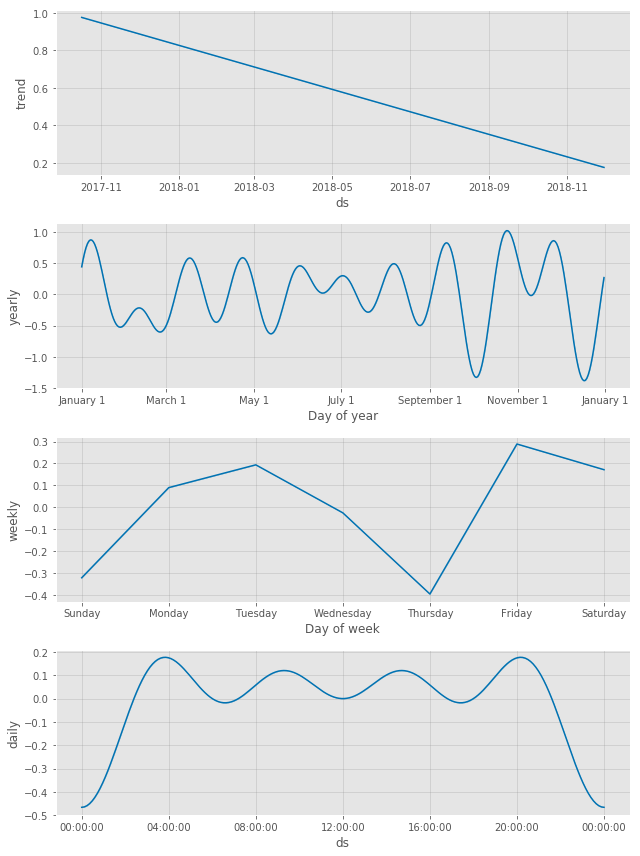

In [618]:
plot_two = no_outliers_model.plot_components(no_outliers_forecast)

Interesting Observations:
- daily plot shows that most tier1 crimes for store 1 happen around early morning 4 and evening 8pm
- weekly plot shows that most tier1 crimes for store 1 happen on Fridays


### Conclusion

#### Forecasted Crime values for Store 1 in all three Crime Categories are the following

##### Forecasted numbers in tier1 :

In [619]:
no_outliers_forecast_exp[(no_outliers_forecast_exp.index >= '2018-06-05') & (no_outliers_forecast_exp.index <= '2018-12-31')].astype(int)

,yhat,yhat_lower,yhat_upper
ds,,,
2018-06-30,1,1,2
2018-07-31,1,1,1
2018-08-31,0,0,1
2018-09-30,0,0,0
2018-10-31,1,1,2
2018-11-30,2,1,2


yhat - predicted value , yhat_lower - lower range , yhat_upper - upper range
Example: for "2018-11-30" date the forecasted crime value is 2 and it lies between 1 and 2 

##### Forecasted numbers in tier2:

In [581]:
no_outliers_forecast_exp2[(no_outliers_forecast_exp2.index >= '2018-06-01') & (no_outliers_forecast_exp2.index <= '2018-12-31')].astype(int)

,yhat,yhat_lower,yhat_upper
ds,,,
2018-06-01,2,0,8
2018-06-02,1,0,4
2018-06-30,0,0,3
2018-07-31,0,0,2
2018-08-31,1,0,5
2018-09-30,0,0,2
2018-10-31,4,1,12
2018-11-30,12,4,40


##### Forecasted numbers in tier3:

In [586]:
no_outliers_forecast_exp3[(no_outliers_forecast_exp3.index >= '2018-06-01') & (no_outliers_forecast_exp3.index <= '2018-12-31')].astype(int)

,yhat,yhat_lower,yhat_upper
ds,,,


zero forecasted crimes for store1 in tier3 because there are only three tier3 incidents in the seattle so it makes sense to see zero forecasted incidents